In [25]:
%matplotlib notebook

In [45]:
import xemc3
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
sys.path.append('/u/phg/adas')
from importlib import reload
import atomdat.adas.ibal_phg as ibal; reload(ibal)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, pyplot as plt

In [46]:
# xemc3 load
philip_folder =  "/u/phg/adas/atomdatpy"
# experiment_folder = "x-exp_NR"
experiment_folder = "N03.00_P05.00_D05_C02.50-TEST"
"N03.00_P05.00_D05_C04.50-TEST"
ds = xr.open_dataset(f"{philip_folder}/{experiment_folder}.nc")
ne, te = np.array(ds["ne"]), np.array(ds["Te"])

In [55]:
ds

<xarray.Dataset>
Dimensions:                (r: 139, theta: 512, phi: 36, delta_r: 2, delta_theta: 2, delta_phi: 2, iteration: 1000)
Coordinates:
    R_bounds               (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    z_bounds               (r, theta, phi, delta_r, delta_theta, delta_phi) float64 ...
    phi_bounds             (phi, delta_phi) float64 ...
  * iteration              (iteration) int64 -999 -998 -997 -996 ... -3 -2 -1 0
Dimensions without coordinates: r, theta, phi, delta_r, delta_theta, delta_phi
Data variables: (12/56)
    _plasma_map            (r, theta, phi) int64 ...
    ne                     (r, theta, phi) float64 nan nan nan ... nan nan nan
    nZ1                    (r, theta, phi) float64 ...
    nZ2                    (r, theta, phi) float64 ...
    nZ3                    (r, theta, phi) float64 ...
    nZ4                    (r, theta, phi) float64 ...
    ...                     ...
    ionization_electron    (iteration) float64 ...
    ionization_ion         (iteration) float64 ...
    ionization_moment_fwd  (iteration) float64 ...
    ionization_moment_bwk  (iteration) float64 ...
    TOTAL_FLX              (iteration) float64 ...
    TOTAL_RAD              (iteration) float64 ...

In [47]:
# lz load
lz_steps = np.load(f"{experiment_folder}_testing_lz.npy")
lz_tot = np.load(f"{experiment_folder}_testing_lz_tot.npy")
E_steps = np.load(f"{experiment_folder}_testing_E.npy") * 1e-12 # convert into W/m^3

# $E_Z$ vs $T_e$

In [49]:
te_res = 300
# *1.01 so that the max value is still inside the last bin. NAN will be outside and can therefore be ignored
te_bins = np.logspace(start=np.log(np.nanmin(te)), stop=np.log(np.nanmax(te)*1.01), num=te_res+1, base=np.e)
te_mask = np.digitize(te, te_bins)

# [te][E0, E1, ... Emax(max=5 for Carbon)]
bin_data1 = np.empty((te_res, 6), dtype="float64")
bin_data1.fill(0) 
bin_data2 = np.empty((te_res, 6), dtype="float64")
bin_data2.fill(0)

for ite in range(te_res):
    # bin 0 is skipped/empty, bin xe_res exists
    bin_mask = (te_mask == ite+1)
    num_entries = np.argwhere(bin_mask).shape[0]
    # print(ite, num_entries)
    
    if num_entries == 0: continue
    
    # E for every ionization step
    # bin_data[ite] = E_steps[bin_mask].sum(axis=0)
    bin_data1[ite] = E_steps[bin_mask].mean(axis=0)
    bin_data2[ite] = E_steps[bin_mask].std(axis=0)

<IPython.core.display.Javascript object>


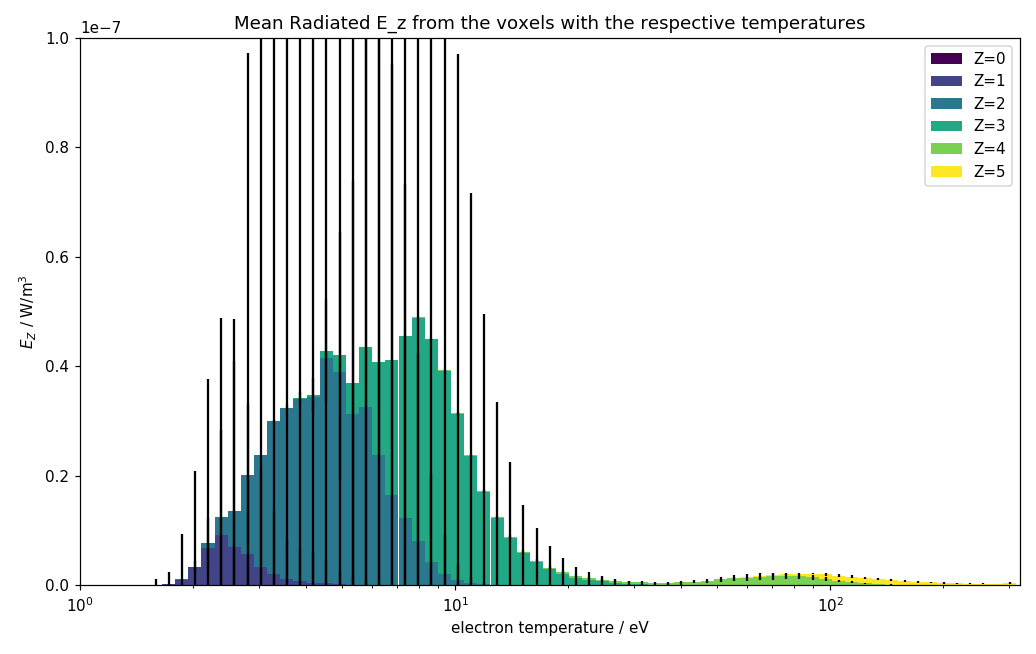

In [53]:
plt.close("all")
fig, ax = plt.subplots(figsize=(9.5,6))
lngth = bin_data1.shape[-1]
colors = cm.get_cmap("viridis", lngth)(np.linspace(0.0, 1.0, lngth))

te_midpoints = np.exp((np.log(te_bins)[:-1] + np.log(te_bins)[1:])/2)
te_widths = np.exp((np.log(te_bins)[:-1] - np.log(te_bins)[1:])/2)

sumarr = np.zeros_like(bin_data1[...,0])
for i in range(lngth):
    ax.bar(te_midpoints, bin_data1[...,i], color=colors[i], width=te_midpoints* 100/4.15 / te_res, 
          bottom=sumarr, label=f"Z={i}", yerr=bin_data2[...,i], linewidth=0.5)
    sumarr += bin_data1[...,i]

ax.set_xlim(1e-0, 3.2e2)
#ax.set_ylim(5e-33, 1e12)
ax.set_ylim(0, 1e-7)
ax.set_xlabel("electron temperature / eV")
ax.set_ylabel("$E_Z$ / W/m$^3$")  # $L_Z$ / Wm$^3$
ax.set_title("Mean Radiated E_z from the voxels with the respective temperatures")
#ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
fig.tight_layout()
fig.savefig("Plots/Ez_stacked_bar")

# $E_Z$ total sum in theoretical calulation from L_z vs IMP_RADIATION

In [54]:
te_res = 300
# *1.01 so that the max value is still inside the last bin. NAN will be outside and can therefore be ignored
te_bins = np.logspace(start=np.log(np.nanmin(te)), stop=np.log(np.nanmax(te)*1.01), num=te_res+1, base=np.e)
te_mask = np.digitize(te, te_bins)

# [te][E0, E1, ... Emax(max=5 for Carbon), IMP_R]
bin_data = np.empty((te_res, 7), dtype="float64")
bin_data.fill(0)  # fill with 0 by default, because if no voxel
# has the temp, then no energy gets radiated a that temperature

rad = np.array(ds["IMP_RADIATION_0"])
for ite in range(te_res):
    # bin 0 is skipped/empty, bin xe_res exists
    bin_mask = (te_mask == ite+1)
    num_entries = np.argwhere(bin_mask).shape[0]
    # print(ite, num_entries)
    
    if num_entries == 0: continue
    
    # E for every ionization step
    # bin_data[ite] = E_steps[bin_mask].sum(axis=0)
    bin_data[ite][:-1] = E_steps[bin_mask].mean(axis=0)
    bin_data[ite][-1] = rad[bin_mask].mean()

KeyError: 'IMP_RADIATION_0'

<IPython.core.display.Javascript object>


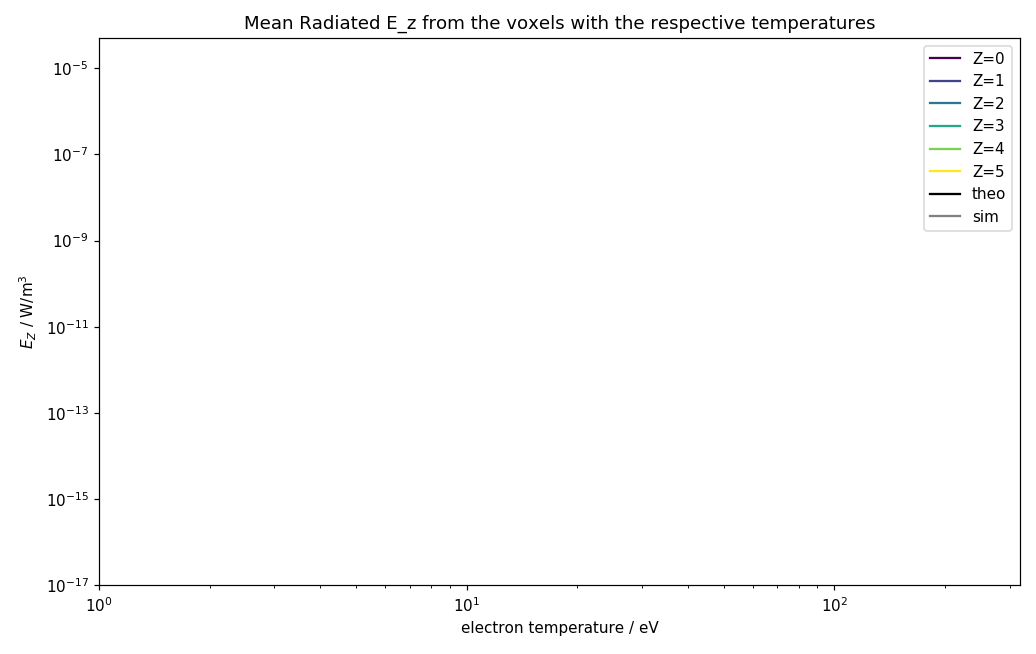

In [56]:
plt.close("all")
fig, ax = plt.subplots(figsize=(9.5,6))
lngth = bin_data.shape[-1] - 1
colors = cm.get_cmap("viridis", lngth)(np.linspace(0.0, 1.0, lngth))

te_midpoints = np.exp((np.log(te_bins)[:-1] + np.log(te_bins)[1:])/2)
te_widths = np.exp((np.log(te_bins)[:-1] - np.log(te_bins)[1:])/2)

sumarr = np.zeros_like(bin_data[...,0])
for i in range(lngth):
    ax.plot(te_midpoints, bin_data[...,i], color=colors[i], label=f"Z={i}")
ax.plot(te_midpoints, bin_data[...,:-1].sum(axis=1), color="k", label=f"theo")
#ax.plot(te_midpoints, bin_data[...,-1]*1e-6, color="gray", label=f"sim")
ax.plot(te_midpoints, -bin_data[...,-1]*1e-6, color="gray", label=f"sim")

ax.set_xlim(1e-0, 3.2e2)
ax.set_ylim(1e-17, 5e-5)
ax.set_xlabel("electron temperature / eV")
ax.set_ylabel("$E_Z$ / W/m$^3$")  # $L_Z$ / Wm$^3$
ax.set_title("Mean Radiated E_z from the voxels with the respective temperatures")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
fig.tight_layout()
fig.savefig("Plots/Ez_log_sum_simulation_calculated")

# mean fractional abundance over te

In [57]:
te.shape

(139, 512, 36)

In [64]:
te_res = 100
# *1.01 so that the max value is still inside the last bin. NAN will be outside and can therefore be ignored
te_bins = np.logspace(start=np.log(np.nanmin(te)), stop=np.log(np.nanmax(te)*1.01), num=te_res+1, base=np.e)
te_mask = np.digitize(te, te_bins)

# [te][]
bin_data1 = np.empty((te_res, 7), dtype="float64")
bin_data1.fill(np.nan)  # fill with nan by default
bin_data2 = np.empty((te_res, 7), dtype="float64")
bin_data2.fill(np.nan)  # fill with nan by default

nzsum = np.array(ds["nZ1"] + ds["nZ2"] + ds["nZ3"] + ds["nZ4"] + ds["nZ5"] +
                 ds["nZ6"] + ds.get("IMPURITY_NEUTRAL_0", 0))
                 
for ioniz in range(7):
    if ioniz == 0:
        nzx = ds.get("IMPURITY_NEUTRAL_0", np.zeros_like(ds["nZ4"]))
    else:
        nzx = np.array(ds[f"nZ{ioniz}"])
    for ite in range(te_res):
        # bin 0 is skipped/empty, bin xe_res exists
        bin_mask = (te_mask == ite+1)
        num_entries = np.argwhere(bin_mask).shape[0]
        #print(te_bins[ite], num_entries)

        if num_entries == 0: continue

        # bin_data1[ite,ioniz] = nzx[bin_mask].sum()/nzsum[bin_mask].sum() global mean, not used
        fractions = (nzx[bin_mask]/nzsum[bin_mask])
        bin_data1[ite,ioniz] = np.nanmean(fractions) # local mean
        bin_data2[ite,ioniz] = np.nanstd(fractions)
    
    

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


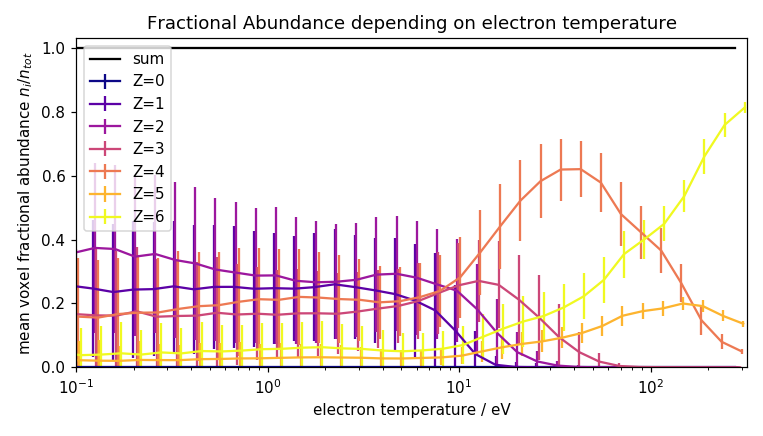

In [65]:
plt.close("all")
fig, ax = plt.subplots(figsize=(7,4))
lngth = bin_data1.shape[-1]
colors = cm.get_cmap("plasma", lngth)(np.linspace(0.0, 1.0, lngth))

te_midpoints = np.exp((np.log(te_bins)[:-1] + np.log(te_bins)[1:])/2)

for i in range(lngth):
    ax.errorbar(te_midpoints*(1+i/50), bin_data1[...,i], color=colors[i], label=f"Z={i}", yerr=bin_data2[...,i])

ax.plot(te_midpoints, bin_data1.sum(axis=1), color="k", label=f"sum") # , yerr=bin_data2[...,i]) 
    
ax.set_xlim(1e-1, 3.2e2)
ax.set_ylim(0, 1.03)
ax.set_xlabel("electron temperature / eV")
ax.set_ylabel("mean voxel fractional abundance $n_i/n_{tot}$")  # $L_Z$ / Wm$^3$
ax.set_title("Fractional Abundance depending on electron temperature")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
fig.tight_layout()
fig.savefig("Plots/fractional_abundances_only.pdf")

# mean fractional abundance theoretical comparison

In [66]:
tex = np.logspace(-0.5,4.,200)
ne = 1e20
newte1,fz1,_, _ = ibal.calc_fz('c', te=tex, ne=ne) # , taua=0)
newte2,fz2,_, _ = ibal.calc_fz('c', te=tex, ne=ne, taua=0.01)
fz1 = fz1.T
fz2 = fz2.T

<IPython.core.display.Javascript object>


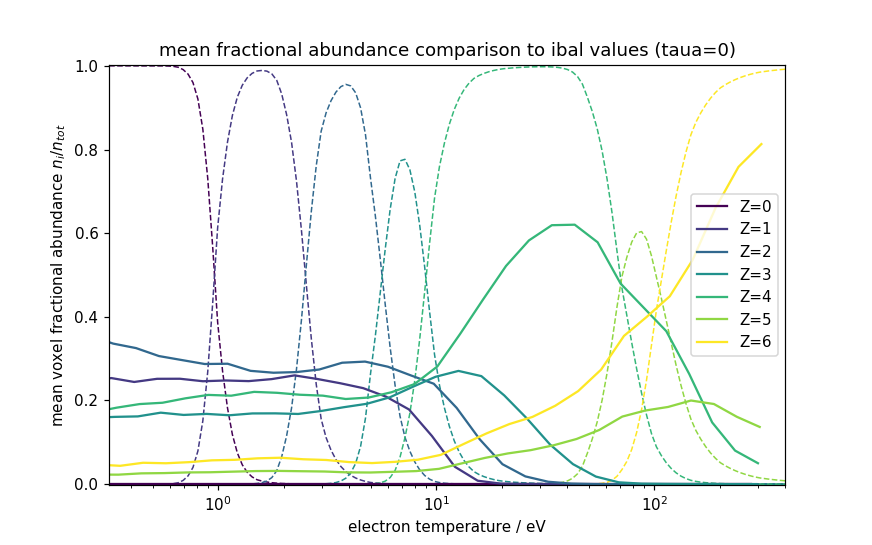

In [67]:
colors = cm.get_cmap("viridis", len(fz1))(np.linspace(0.0, 1.0, len(fz1)))
plt.close("all")
fig, ax = plt.subplots(figsize=(8,5))

for i, fi in enumerate(fz1):
    ax.plot(newte1, fi, c=colors[i], linestyle="--", lw=1)
# for i, fi in enumerate(fz2):
#     ax.plot(newte2, fi, c=colors[i], linestyle=":", lw=1)

for i in range(bin_data1.shape[-1]):
    ax.plot(te_midpoints*(1+i/50), bin_data1[...,i], color=colors[i], label=f"Z={i}")
    #ax.errorbar(te_midpoints*(1+i/50), bin_data1[...,i], color=colors[i], label=f"Z={i}", yerr=bin_data2[...,i])

ax.set_xlabel("electron temperature / eV")
ax.set_ylabel("mean voxel fractional abundance $n_i/n_{tot}$")  # $L_Z$ / Wm$^3$
ax.set_title("mean fractional abundance comparison to ibal values (taua=0)")
#ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(0.316,400)
#ax.set_ylim(1e-14, 1e-0)
ax.set_ylim(-0.002,1.002)
ax.legend()
fig.savefig("Plots/Ez_log_sum_simulation_calculated")
fig.savefig("../images/img3.png", dpi=200)

In [16]:
# sanity check: ionisation step 6 seems to be practicaly nonexistant

<IPython.core.display.Javascript object>


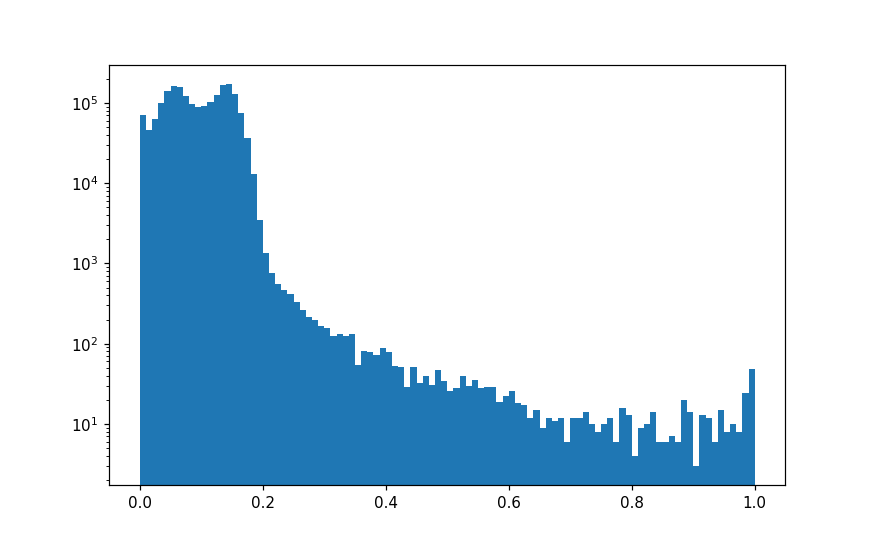

In [19]:
plt.close("all")
fig, ax = plt.subplots(figsize=(8,5))
distr6 = np.array(ds["nZ5"]/(ds["nZ1"] + ds["nZ2"] + ds["nZ3"] + ds["nZ4"] + 
                             ds["nZ5"] + ds["nZ6"] + ds["nZ7"])).flatten()
ax.hist(distr6, bins=100)
ax.set_yscale("log")

# n0 or nH plot over Te

In [20]:
te_res = 100
# *1.01 so that the max value is still inside the last bin. NAN will be outside and can therefore be ignored
te_bins = np.logspace(start=np.log(np.nanmin(te)), stop=np.log(np.nanmax(te)*1.01), num=te_res+1, base=np.e)
te_mask = np.digitize(te, te_bins)

# [te][]
bin_data1 = np.empty((te_res, 2), dtype="float64")
bin_data1.fill(np.nan)  # fill with nan by default

nH = np.array(ds["nH"])
for ite in range(te_res):
    # bin 0 is skipped/empty, bin xe_res exists
    bin_mask = (te_mask == ite+1)
    num_entries = np.argwhere(bin_mask).shape[0]
    # print(ite, num_entries)

    if num_entries == 0: continue

    bin_data1[ite,0] = np.nanmean(nH[bin_mask])
    bin_data1[ite,1] = np.nanstd(nH[bin_mask])

<IPython.core.display.Javascript object>


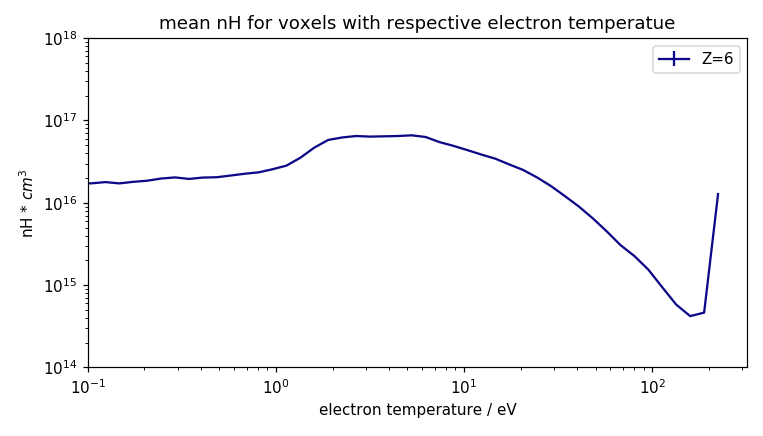

In [23]:
plt.close("all")
fig, ax = plt.subplots(figsize=(7,4))
lngth = bin_data1.shape[-1]
colors = cm.get_cmap("plasma", lngth)(np.linspace(0.0, 1.0, lngth))

te_midpoints = np.exp((np.log(te_bins)[:-1] + np.log(te_bins)[1:])/2)

ax.errorbar(te_midpoints*(1+i/50), bin_data1[...,0], color=colors[0], label=f"Z={i}", yerr=bin_data2[...,1])
    
ax.set_xlim(1e-1, 3.2e2)
ax.set_ylim(1e14, 1e18)
ax.set_xlabel("electron temperature / eV")
ax.set_ylabel("nH * $cm^3$")  # $L_Z$ / Wm$^3$
ax.set_title("mean nH for voxels with respective electron temperatue")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
fig.tight_layout()
fig.savefig("Plots/nHmean.pdf")

<IPython.core.display.Javascript object>


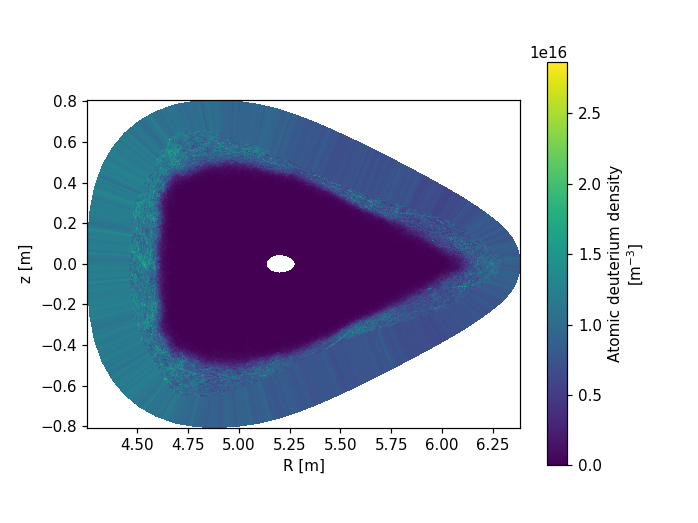

In [24]:
fig, ax = plt.subplots()
ds.emc3.plot_rz("nH", 36*np.pi/180, ax=ax)

In [25]:
ds["nHlog"] = np.log(ds["nH"])
ds["nHlog"].attrs["units"] = 'log(m$^{-3}$)'
ds["nHlog"].attrs["long_name"] = 'Logarithmic Atomic deuterium density'

<IPython.core.display.Javascript object>


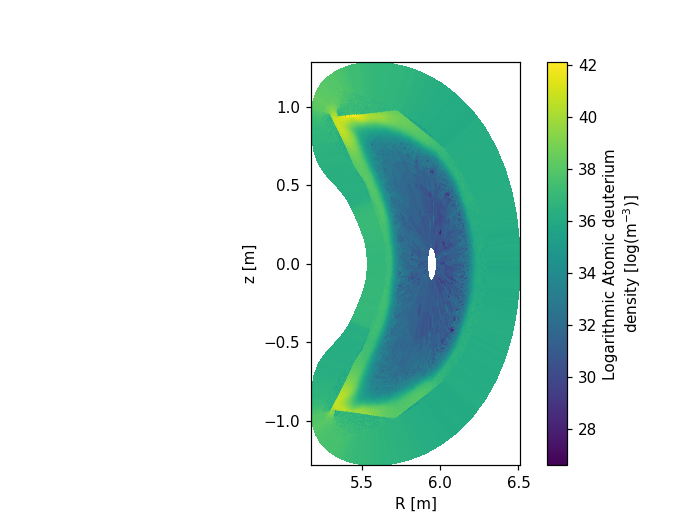

In [26]:
fig, ax = plt.subplots()
ds.emc3.plot_rz("nHlog", 0*np.pi/180, ax=ax)

In [1]:
hey

NameError: name 'hey' is not defined